In [1]:
import pandas as pd
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import json
from pathlib import Path
from kneed import KneeLocator

# font_path = '/home/dhester/.fonts/InterVariable.ttf'
font_path = r"C:\Users\dh2306\AppData\Local\Microsoft\Windows\Fonts\Inter-VariableFont_opsz,wght.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.style.use('seaborn-v0_8-darkgrid')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [2]:
dfs = []
for dir in glob('../runs/s2flow_sr_sampling_sweep/20251117_094927/*/*/*/'):
    dir = Path(dir)
    print(dir)
    # continue
    path_parts = dir.parts
    
    sampler = path_parts[4]
    # if sampler != 'euler':
    #     continue
    steps = int(path_parts[5].split('_')[1])
    
    csv_path = dir / 'sr_evaluation_summary_stats.csv'
    if not os.path.exists(csv_path):
        print(f"Skipping {dir}, no csv found")
        continue
    
    metrics_df = pd.read_csv(csv_path)
    num_samples = metrics_df['count'].iloc[0]
    metrics_df = metrics_df.drop(columns=['count'])
    metrics_df = metrics_df.set_index('metric')
    metrics_df = metrics_df.stack().reset_index()
    metrics_df.columns = ['metric', 'stat', 'value']
    metrics_df['column'] = metrics_df['metric'] + '_' + metrics_df['stat']
    metrics_df = metrics_df.pivot(columns='column', values='value')
    # select first non-Nan entry for each column
    metrics_df = metrics_df.ffill().bfill().iloc[0]
    metrics_df = metrics_df.to_frame().T
    metrics_df['sampler'] = sampler
    metrics_df['steps'] = steps
    
    with open(dir / 'sr_evaluation_times.json', 'r') as f:
        times = json.load(f)
    
    metrics_df['total_time_seconds'] = times['total_time_seconds']
    metrics_df['gpu_sampling_time_seconds'] = times['gpu_sampling_time_seconds']
    metrics_df['num_samples'] = num_samples
    
    metrics_df['gpu_time_per_sample_seconds'] = metrics_df['gpu_sampling_time_seconds'] / num_samples
    dfs.append(metrics_df)
    
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(by='steps')

..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_1\s2flow_eval_euler_steps1
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_10\s2flow_eval_euler_steps10
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_100\s2flow_eval_euler_steps100
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_15\s2flow_eval_euler_steps15
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_20\s2flow_eval_euler_steps20
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_25\s2flow_eval_euler_steps25
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_30\s2flow_eval_euler_steps30
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_35\s2flow_eval_euler_steps35
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_40\s2flow_eval_euler_steps40
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_45\s2flow_eval_euler_steps45
..\runs\s2flow_sr_sampling_sweep\20251117_094927\euler\steps_5\s2flow_eval_euler_steps5
..\runs\s2fl

In [3]:
df.to_csv('../runs/s2flow_sr_sampling_sweep/20251117_094927/summary_sampling_metrics.csv', index=False)

In [4]:
sample_metrics_dfs = []
for csv in glob('../runs/s2flow_sr_sampling_sweep/20251117_094927/*/*/*/sr_evaluation_metrics.csv'):
    csv = Path(csv)
    csv_pars = csv.parts
    sampler = csv_pars[4]
    steps = int(csv_pars[5].split('_')[1])
    sample_metrics_df = pd.read_csv(csv)
    sample_metrics_df['sampler'] = sampler
    sample_metrics_df['steps'] = steps
    sample_metrics_dfs.append(sample_metrics_df)
    
sample_metrics_df = pd.concat(sample_metrics_dfs, ignore_index=True)
sample_metrics_df.to_parquet('../runs/s2flow_sr_sampling_sweep/20251117_094927/per_sample_metrics.par', index=False)

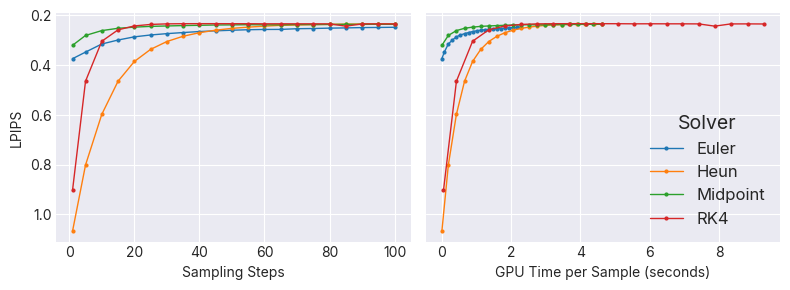

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8,6), sharey=True, sharex=True)

sampler_names = {
    'euler': 'Euler',
    'midpoint': 'Midpoint',
    'heun': 'Heun',
    'rk4': 'RK4',
}

linewidth = 1
markersize = 2

for i, (sampler, group) in enumerate(df.groupby('sampler')):
    ax[0][0].plot(group['steps'], group['LPIPS_mean'], marker='o', label=sampler_names[sampler], color=f'C{i}', linewidth=linewidth, markersize=markersize)
    ax[0][1].plot(group['gpu_time_per_sample_seconds'], group['LPIPS_mean'], marker='o', label=sampler_names[sampler], color=f'C{i}', linewidth=linewidth, markersize=markersize)

for i, (sampler, group) in enumerate(df.groupby('sampler')):
    ax[1][0].plot(group['steps'], group['PSNR_mean'], marker='o', label=sampler_names[sampler], color=f'C{i}', linewidth=linewidth, markersize=markersize)
    ax[1][1].plot(group['gpu_time_per_sample_seconds'], group['PSNR_mean'], marker='o', label=sampler_names[sampler], color=f'C{i}', linewidth=linewidth, markersize=markersize)

ax[1].legend(title='Solver', fontsize=12, title_fontsize=14)
ax[0].set_xlabel('Sampling Steps')
ax[1].set_xlabel('GPU Time per Sample (seconds)')
ax[0].set_ylabel('LPIPS')
ax[0].invert_yaxis()



fig.tight_layout()

# fig_dir = Path('../figures/sampling_performance/')
# for filetype in ['png', 'pdf']:
    
#     fig_dir.mkdir(parents=True, exist_ok=True)
#     out_path = fig_dir / f'sampling_performance.{filetype}'
#     plt.savefig(out_path, dpi=300 if filetype=='png' else None, bbox_inches='tight')
    
# plt.savefig('../runs/s2flow_sr_sampling_sweep/20251117_094927/sampling_performance.pdf', dpi=300)

In [6]:
optimal_steps = {
    sampler: KneeLocator(
        group['steps'],
        group['DISTS_mean'],
        curve='convex',
        direction='decreasing'
    ).knee
    for sampler, group in df.groupby('sampler')
}

optimal_samples_gdf = df[
    (df['sampler'].map(optimal_steps) == df['steps'])
]
optimal_samples_gdf.sort_values(by='LPIPS_mean')[['sampler', 'steps', 'DISTS_mean', 'LPIPS_mean', 'gpu_time_per_sample_seconds']]

column,sampler,steps,DISTS_mean,LPIPS_mean,gpu_time_per_sample_seconds
45,midpoint,15,0.248095,0.251533,0.661248
66,rk4,15,0.245791,0.257702,1.359526
6,euler,30,0.254912,0.273008,0.661598
26,heun,25,0.277048,0.336208,1.130068


In [7]:
df.loc[(df['sampler'] == 'midpoint') & (df['steps'] == 15)]['LPIPS_mean']

45    0.251533
Name: LPIPS_mean, dtype: float64

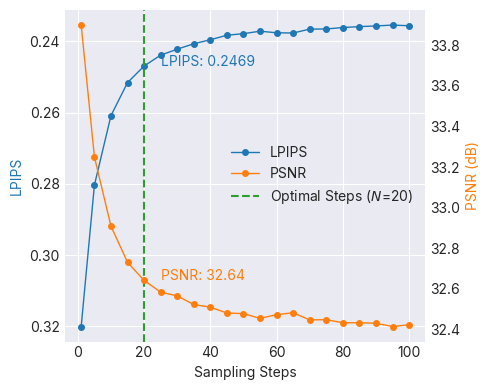

In [35]:
# determine optimal number of steps based on LPIPS elbow

midpoint_df = df[df['sampler'] == 'midpoint']

knee_locator = KneeLocator(
    midpoint_df['steps'],
    midpoint_df['LPIPS_mean'],
    curve='convex',
    direction='decreasing',
)
knee = knee_locator.knee

optimal_LPIPS = midpoint_df.loc[midpoint_df['steps'] == knee, 'LPIPS_mean'].values[0]
optimal_psnr = midpoint_df.loc[midpoint_df['steps'] == knee, 'PSNR_mean'].values[0]

fig, ax = plt.subplots(figsize=(5, 4))
# plot both PSNR and LPIPS on same plot with different y-axes
ax2 = ax.twinx()
ax.plot(midpoint_df['steps'], midpoint_df['LPIPS_mean'], marker='o', color='C0', label='LPIPS', linewidth=linewidth, markersize=markersize*2)
ax2.plot(midpoint_df['steps'], midpoint_df['PSNR_mean'], marker='o', color='C1', label='PSNR', linewidth=linewidth, markersize=markersize*2)
ax.axvline(x=knee, color='C2', linestyle='--', label=f'Optimal Steps ($N$={knee})')
ax.set_xlabel('Sampling Steps')
ax.set_ylabel('LPIPS', color='C0')
ax2.set_ylabel('PSNR (dB)', color='C1')

legend_handles = []
lines, labels = ax.get_legend_handles_labels()
legend_handles.extend(zip(lines, labels))
lines, labels = ax2.get_legend_handles_labels()
legend_handles.extend(zip(lines, labels))
# swap the middle and last legend entries to have optimal steps at the end
legend_handles[1], legend_handles[2] = legend_handles[2], legend_handles[1]
ax.legend(*zip(*legend_handles), loc='center right')
# disable grid on ax2
ax2.grid(False)

# show LPIPS and PSNR values at optimal steps
ax.text(knee + 5, optimal_LPIPS, f'LPIPS: {optimal_LPIPS:.4f}', color='C0')
ax2.text(knee + 5, optimal_psnr, f'PSNR: {optimal_psnr:.2f}', color='C1')

# set plot visual ratio to 1:1
ax.set_aspect('auto')
fig.tight_layout()

# flip y-axis of LPIPS to match PSNR direction
ax.invert_yaxis()

fig_dir = Path('../figures/sampling_performance/')
fig_dir.mkdir(parents=True, exist_ok=True)
for filetype in ['png', 'pdf']:
    
    # out_path = f'../runs/s2flow_sr_sampling_sweep/20251117_094927/figures/midpoint_optimal_steps.{filetype}'
    out_path = fig_dir / f'midpoint_optimal_steps.{filetype}'
    
    plt.savefig(out_path, dpi=300 if filetype=='png' else None) # file is getting cut off

In [9]:
euler_psnr = df.loc[(df['sampler'] == 'euler') & (df['steps'] == 1), 'PSNR_mean'].iloc[0]
mid_psnr = df.loc[(df['sampler'] == 'midpoint') & (df['steps'] == 1), 'PSNR_mean'].iloc[0]
print(f"Euler PSNR (1 step): {euler_psnr:.2f}")
print(f"Midpoint PSNR (1 step): {mid_psnr:.2f}")

Euler PSNR (1 step): 34.95
Midpoint PSNR (1 step): 33.90


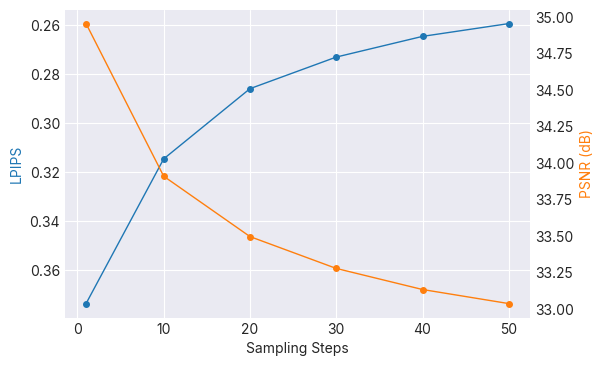

In [36]:
# show euler PSNR and LPIPS for 1, 10, 20, 30, 40, 50 steps
euler_df = df[df['sampler'] == 'euler']
euler_steps = [1, 10, 20, 30, 40, 50]
euler_subset = euler_df[euler_df['steps'].isin(euler_steps)][['steps', 'PSNR_mean', 'LPIPS_mean']]
# euler_subset['1 - LPIPS_mean'] = 1 - euler_subset['LPIPS_mean']
# euler_subset = euler_subset.set_index('steps')

fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

ax.plot(euler_subset['steps'], euler_subset['LPIPS_mean'], marker='o', label='PSNR', color='C0', linewidth=linewidth, markersize=markersize*2)
ax.set_ylabel('LPIPS', color='C0')
ax2 = ax.twinx()
ax2.plot(euler_subset['steps'], euler_subset['PSNR_mean'], marker='o', label='LPIPS', color='C1', linewidth=linewidth, markersize=markersize*2)
ax2.set_ylabel('PSNR (dB)', color='C1')
ax2.grid(False)
ax.set_xlabel('Sampling Steps')
ax.invert_yaxis()
# ax.set_title('Euler Sampler Performance')